**Importing Essential Libraries**


In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
import cv2
import tensorflow as tf
import pickle

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D ,AveragePooling2D, Flatten, Dropout
from keras.layers.core import Dense
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


**Unzipping the Train and Test sets**

In [2]:
os.getcwd()

'/content'

In [0]:
handle_train=zipfile.ZipFile(r'/content/Train.zip')
handle_train.extractall('/content/train')
handle_train.close()
handle_test=zipfile.ZipFile(r'/content/Test.zip')
handle_test.extractall('/content/test')
handle_test.close()

In [0]:
train_images=os.listdir('/content/train/Train/')
test_images = os.listdir('/content/test/Test')

filepath_train = '/content/train/Train/'
filepath_test = '/content/test/Test/' 

In [5]:
df_train = pd.read_csv('/content/train.csv')
df_train.head(10)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
5,6283.jpg,MIDDLE
6,23495.jpg,YOUNG
7,7100.jpg,YOUNG
8,6028.jpg,YOUNG
9,22617.jpg,OLD


In [6]:
sample_submn = pd.read_csv('/content/sample_submission_sDO3m7O.csv')
sample_submn.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


**Reading & Resizing Training and Testing images**

In [0]:

images=[]
labels=[]

for index, row in df_train.iterrows():
  image=cv2.imread(filepath_train+row['ID'])
  image=cv2.resize(image , (64,64))
  images.append(image)
  labels.append(row['Class'])
  #print(row['ID'])


In [0]:
images_test=[]
outputs=[]

for index,row in sample_submn.iterrows():
  image=cv2.imread(filepath_test+row['ID'])
  image=cv2.resize(image , (64,64))
  images_test.append(image) 
  outputs.append(image)

**Displaying couple of images for Sanity check**

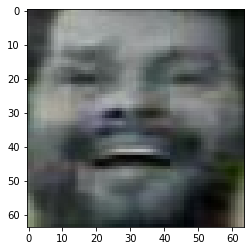

In [9]:
plt.imshow(images[0])

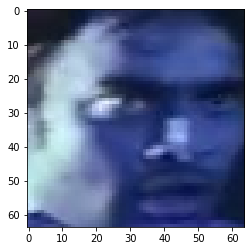

In [10]:
plt.imshow(images[1])

In [11]:
df_train.tail()

,ID,Class
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE
19905,9896.jpg,MIDDLE


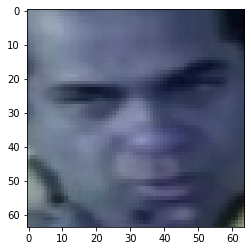

In [12]:
plt.imshow(images[-1])

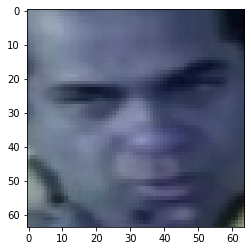

In [13]:
plt.imshow(images[19905])

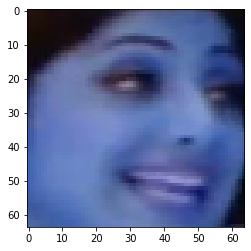

In [14]:
plt.imshow(images[19904])

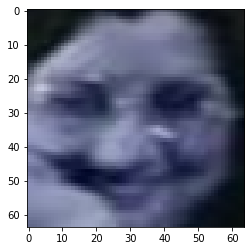

In [15]:
plt.imshow(images_test[0])

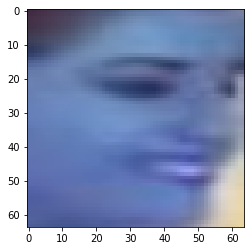

In [16]:
plt.imshow(images_test[-1])

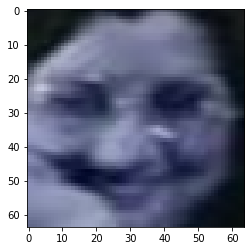

In [17]:
plt.imshow(outputs[0])

Converting into an n-d array and normalizing the image pixels

In [0]:
images = np.array(images, dtype="float") / 255.0
images_test = np.array(images_test, dtype="float") / 255.0
labels = np.array(labels)

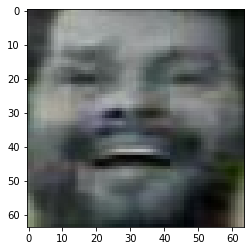

In [19]:
plt.imshow(images[0])

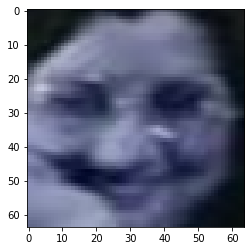

In [20]:
plt.imshow(images_test[0])

**Splitting into train and test set for training**

In [0]:
(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.20, random_state=42)

In [22]:
print(type(trainX))
print(trainX.shape)
print(type(trainY))
print(trainY.shape)
print(type(testX))
print(testX.shape)
print(type(testY))
print(testY.shape)

<class 'numpy.ndarray'>
(15924, 64, 64, 3)
<class 'numpy.ndarray'>
(15924,)
<class 'numpy.ndarray'>
(3982, 64, 64, 3)
<class 'numpy.ndarray'>
(3982,)


Binarizing the output categories 

In [0]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [24]:
lb.classes_

array(['MIDDLE', 'OLD', 'YOUNG'], dtype='<U6')

**Model Implementation**

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = "same", activation ='relu', input_shape = (64,64,3)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(3,activation="softmax"))


In [0]:
INIT_LR = 0.01
EPOCHS = 75
BS = 32

opt=SGD(lr=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])

**Image Data Augmentation**

In [0]:
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.1,horizontal_flip=True, fill_mode="nearest")

**Fitting the model onto the training set**

In [28]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,epochs=EPOCHS)

Epoch 1/75
497/497 [==============================] - 28s 56ms/step - loss: 1.1266 - accuracy: 0.5212 - val_loss: 0.9824 - val_accuracy: 0.5560
Epoch 2/75
497/497 [==============================] - 21s 42ms/step - loss: 0.8463 - accuracy: 0.6136 - val_loss: 0.9639 - val_accuracy: 0.5743
Epoch 3/75
497/497 [==============================] - 21s 42ms/step - loss: 0.8123 - accuracy: 0.6325 - val_loss: 0.7760 - val_accuracy: 0.6303
Epoch 4/75
497/497 [==============================] - 21s 42ms/step - loss: 0.7878 - accuracy: 0.6522 - val_loss: 0.7325 - val_accuracy: 0.6841
Epoch 5/75
497/497 [==============================] - 21s 42ms/step - loss: 0.7743 - accuracy: 0.6559 - val_loss: 0.7434 - val_accuracy: 0.6612
Epoch 6/75
497/497 [==============================] - 21s 42ms/step - loss: 0.7603 - accuracy: 0.6661 - val_loss: 0.6983 - val_accuracy: 0.7024
Epoch 7/75
497/497 [==============================] - 21s 43ms/step - loss: 0.7484 - accuracy: 0.6685 - val_loss: 0.6877 - val_accuracy:

In [29]:
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))

              precision    recall  f1-score   support

      MIDDLE       0.88      0.84      0.86      2181
         OLD       0.67      0.78      0.72       471
       YOUNG       0.84      0.84      0.84      1330

    accuracy                           0.84      3982
   macro avg       0.80      0.82      0.81      3982
weighted avg       0.84      0.84      0.84      3982



**Loss-Accuracy Tradeoff graph**

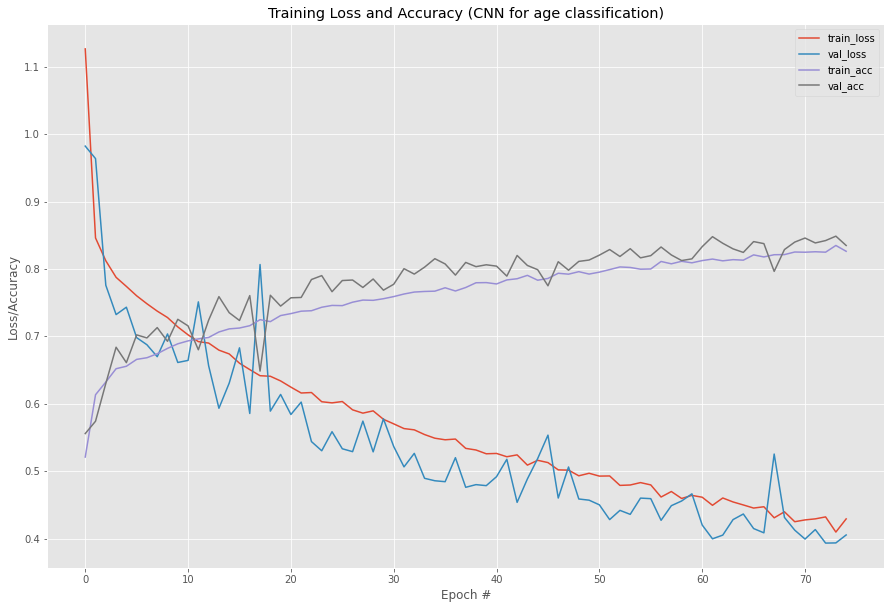

In [30]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (CNN for age classification)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

**Predicting for test set values**

In [31]:
pred = model.predict(images_test)
pred

array([[8.6847949e-01, 7.7840999e-02, 5.3679496e-02],
       [5.2854111e-03, 1.6360056e-04, 9.9455100e-01],
       [2.7831966e-01, 2.4152505e-01, 4.8015535e-01],
       ...,
       [9.0461791e-01, 7.7032998e-02, 1.8349117e-02],
       [9.4515502e-01, 4.0456481e-02, 1.4388469e-02],
       [2.1795204e-02, 4.4586044e-02, 9.3361872e-01]], dtype=float32)

In [32]:
i = pred.argmax(axis=1)
i

array([0, 2, 2, ..., 0, 0, 2])

In [33]:
#Going for second test example 
i1 = pred.argmax(axis=1)[1]
i1

2

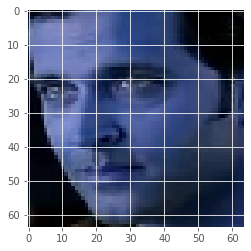

In [34]:
plt.imshow(images_test[1])

In [35]:
vals = np.amax(pred, axis=1)
vals

array([0.8684795 , 0.994551  , 0.48015535, ..., 0.9046179 , 0.945155  ,
       0.9336187 ], dtype=float32)

In [36]:
#going for second test example
val1 = vals[1]
val1

0.994551

In [37]:
#second test example
perc_val1 = val1*100
perc_val1 = perc_val1.round(2)
perc_val1

99.46

In [0]:
from google.colab.patches import cv2_imshow

In [39]:
label1 = lb.classes_[i1]
label1

'YOUNG'

**Displaying final image again after classification**

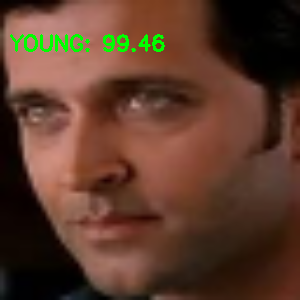

-1

In [40]:
text = label1+": "+str(perc_val1)
#text='.'

outputs[1] = cv2.resize(outputs[1] , (300,300))
cv2.putText(outputs[1], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[1])
cv2.waitKey(0)

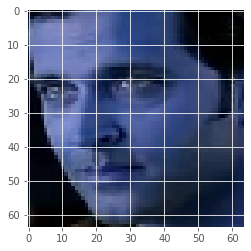

In [41]:
plt.imshow(images_test[1])

In [42]:
output_labels = lb.classes_[i]
output_labels

array(['MIDDLE', 'YOUNG', 'YOUNG', ..., 'MIDDLE', 'MIDDLE', 'YOUNG'],
      dtype='<U6')

In [43]:
submission = pd.DataFrame({'Class':output_labels,'ID':sample_submn['ID']})
submission

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,YOUNG,19277.jpg
3,MIDDLE,13093.jpg
4,OLD,5367.jpg
...,...,...
6631,OLD,1876.jpg
6632,MIDDLE,14940.jpg
6633,MIDDLE,3638.jpg
6634,MIDDLE,376.jpg


In [0]:
#submission.to_csv('submission3_age_classif.csv',index=False)

In [0]:
#from google.colab import files
#files.download("submission3_age_classif.csv")

In [46]:
#Going for fourth test example 
i3 = pred.argmax(axis=1)[3]
i3

0

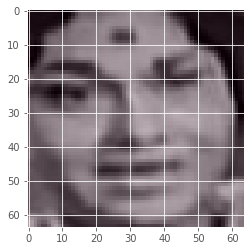

In [47]:
plt.imshow(images_test[3])

In [48]:
val3 = vals[3]
val3

0.987058

In [49]:
#second test example
perc_val3 = val3*100
perc_val3 = perc_val3.round(2)
perc_val3

98.71

In [50]:
label3 = lb.classes_[i3]
label3

'MIDDLE'

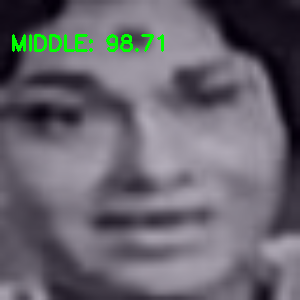

-1

In [51]:
text = label3+": "+str(perc_val3)
#text='.'

outputs[3] = cv2.resize(outputs[3] , (300,300))
cv2.putText(outputs[3], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[3])
cv2.waitKey(0)

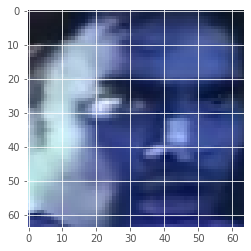

In [52]:
plt.imshow(images[1])

In [53]:
#Going for 6634 test example 
i6631 = pred.argmax(axis=1)[6631]
i6631

1

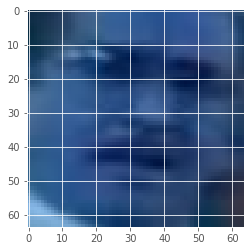

In [54]:
plt.imshow(images_test[6631])

In [55]:
val6631 = vals[6631]
val6631

0.8644119

In [56]:
#second test example
perc_val6631 = val6631*100
perc_val6631 = perc_val6631.round(2)
perc_val6631

86.44

In [57]:
label6631 = lb.classes_[i6631]
label6631

'OLD'

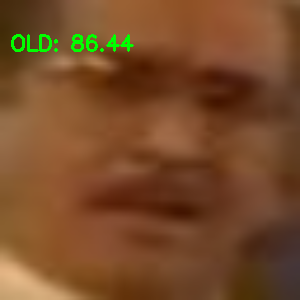

-1

In [58]:
text = label6631+": "+str(perc_val6631)
#text='.'

outputs[6631] = cv2.resize(outputs[6631] , (300,300))
cv2.putText(outputs[6631], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[6631])
cv2.waitKey(0)

In [59]:
sample_submn[sample_submn['ID'] == '2456.jpg']

,Class,ID
3533,MIDDLE,2456.jpg


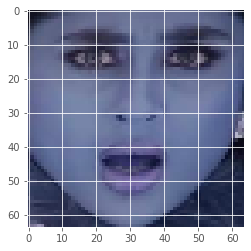

In [60]:
plt.imshow(images_test[3533])

In [61]:
#Going for second test example 
i3533 = pred.argmax(axis=1)[3533]
i3533

2

In [62]:
val3533 = vals[3533]
val3533

0.9694383

In [63]:
perc_val3533 = val3533*100
perc_val3533 = perc_val3533.round(2)
perc_val3533

96.94

In [64]:
label3533 = lb.classes_[i3533]
label3533

'YOUNG'

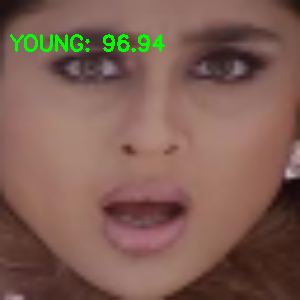

-1

In [65]:
text = label3533+": "+str(perc_val3533)
#text='.'

outputs[3533] = cv2.resize(outputs[3533] , (300,300))
cv2.putText(outputs[3533], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[3533])
cv2.waitKey(0)

**Exporting .h5 and .json files for Deployment in Flask**

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")

In [0]:
from google.colab import files
files.download("model.h5")

In [0]:
from google.colab import files
files.download("model.json")